In [1]:
import numpy as np
from tifffile import imread, imsave

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

from scipy.ndimage.morphology import distance_transform_edt
import itk

from aicssegmentation.core.visual import blob2dExplorer_single, random_colormap
from aicssegmentation.core.seg_dot import dot_2d
from aicssegmentation.core.utils import hole_filling
from aicssegmentation.core.pre_processing_utils import intensity_normalization, suggest_normalization_param, edge_preserving_smoothing_3d

## load one example image

In [2]:
img = imread('./Harvard_Lung/LUNG-1-LN/LUNG-1-LN_40X_1.tif')

In [3]:
img.shape

(10101, 9666)

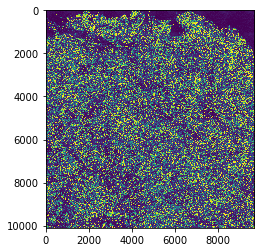

In [4]:
plt.imshow(img)

## crop a small area for algorithm development

In [5]:
img = img[1000:1512,3000:3512]

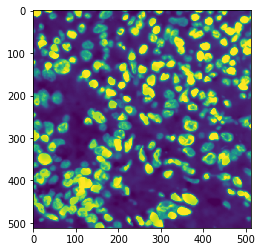

In [6]:
plt.imshow(img)

## pre-processing: intensity normalization and smoothing

In [7]:
suggest_normalization_param(img)

mean intensity of the stack: 22418.06343460083
the standard deviation of intensity of the stack: 20944.790982222265
0.9999 percentile of the stack intensity is: 65535.0
minimum intensity of the stack: 0
maximum intensity of the stack: 65535
suggested upper range is 2.0, which is 64307.64539904536
suggested lower range is 1.0, which is 1473.2724523785655
So, suggested parameter for normalization is [1.0, 2.0]
To further enhance the contrast: You may increase the first value (may loss some dim parts), or decrease the second value(may loss some texture in super bright regions)
To slightly reduce the contrast: You may decrease the first value, or increase the second value


In [8]:
img_norm = intensity_normalization(img, [1.0, 2.0])

intensity normalization: normalize into [mean - 1.0 x std, mean + 2.0 x std] 
intensity normalization completes


In [9]:
img_smooth = edge_preserving_smoothing_3d(img_norm)

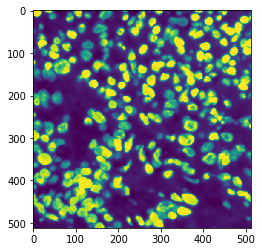

In [10]:
plt.imshow(img_smooth)

## try blob detection

In [11]:
interact(blob2dExplorer_single, im=fixed(img_smooth), \
         sigma=widgets.FloatRangeSlider(value=[1,5], min=1, max=11,step=1,continuous_update=False),  \
         th=widgets.FloatSlider(value=0.05,min=0.01, max=0.5, step=0.01,continuous_update=False));

interactive(children=(FloatRangeSlider(value=(1.0, 5.0), continuous_update=False, description='sigma', max=11.…

## apply the optimal parameters found in previous step

In [12]:
img_dot_detection = dot_2d(img_smooth, 5)

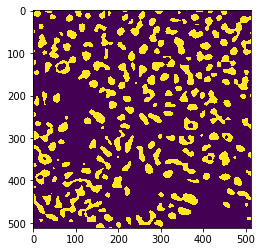

In [13]:
pre_mask = img_dot_detection>0.1
plt.imshow(pre_mask)

## use watershed to cut falsely merged nuclei

In [14]:
refined_mask = hole_filling(pre_mask, 1, 400)

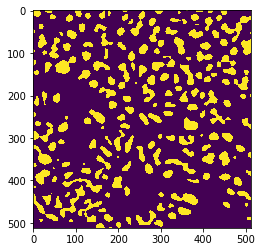

In [15]:
plt.imshow(refined_mask)

In [16]:
# watershed without seed in tik
watershed_map = -1*distance_transform_edt(pre_mask)
itk_raw = itk.GetImageFromArray(watershed_map.astype(np.float32))
watershed_result = itk.watershed_image_filter(itk_raw, threshold=0.01, level=0.28)
new_label = itk.GetArrayFromImage(watershed_result)

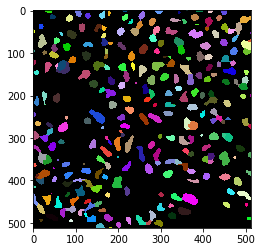

In [17]:
plt.imshow(new_label, cmap=random_colormap())

In [18]:
imsave('test.tiff', new_label.astype(np.uint16))